# Kuramoto Model

In [1]:
import importlib

# List of libraries to check
libraries = [
    'numpy',
    'matplotlib',
    'scipy',
    'torch',
    'torchdiffeq',
    'torchsummary',
    'minepy',
    'pyrqa',
    'pyts',
    'MFDFA',
    'pyinform',
    'graphviz',
    'fa2',
    'networkx'
]

for lib in libraries:
    try:
        module = importlib.import_module(lib)
        version = getattr(module, '__version__', 'Unknown version')
        print(f'{lib}: {version}')
    except ImportError:
        print(f'{lib} is not installed.')

numpy: 1.24.3
matplotlib: 3.7.0
scipy: 1.10.1
torch: 2.0.1+cu117
torchdiffeq: 0.2.3
torchsummary: Unknown version
minepy: b'1.2.6'
pyrqa: Unknown version
pyts: 0.12.0
MFDFA: 0.4.3
pyinform: Unknown version
graphviz: 0.20.1
fa2 is not installed.
networkx: 3.0


# Regional Avg

<div style="font-size: 14px; font-family: 'Times New Roman', Times, serif; background-color: #181818; color: #D0D0D0; padding: 20px; border-radius: 8px; margin: 10px; display: flex; flex-wrap: nowrap; justify-content: space-between;">
    <!-- Column 1 -->
    <div style="flex: 1; margin-right: 10px;">
        <h2>Introduction</h2>
        <p>In a concerted effort to model the complex dynamics of brain activity as captured in EEG recordings, we leverage the extended Kuramoto model - a paradigm that describes a system of coupled phase oscillators. The model is tailored to embody the nuances of inter-regional interactions within the brain, as inferred from EEG data. By segmenting the brain into broad regions and evaluating the Phase Locking Value (PLV) and phase differences between these regions, we formulate a model that encapsulates both the natural frequencies of oscillation and the inherent coupling between different brain areas.</p>
        <h2>Mathematical Foundations</h2>
        <p>The classical Kuramoto model is extended to include weighted coupling and phase bias. The governing equation for the phase evolution of region \(i\) is given by:</p>
        \[ \frac{d\theta_i}{dt} = \omega_i + \frac{K}{N} \sum_{j=1}^N W_{ij} \sin(\theta_j - \theta_i - \alpha_{ij}) \]
        <p>where \( \theta_i \) is the phase of region \(i\), \( \omega_i \) is its natural frequency, \(K\) is the global coupling strength, \( N \) is the number of regions, \( W_{ij} \) is the weight of coupling from region \(j\) to region \(i\), and \( \alpha_{ij} \) is the phase bias between regions \(i\) and \(j\).</p>
        <p>The weights \( W_{ij} \) are derived from the PLV matrix, which represents the phase synchrony between different EEG channels. The phase biases \( \alpha_{ij} \) are computed from the mean phase differences between the corresponding regions. These modifications to the Kuramoto model embody the empirical relations observed in the EEG data, thus fostering a realistic representation of the inter-regional dynamics within the brain.</p>
        <h2>Phase Locking Value (PLV) and Phase Differences</h2>
        <p>PLV is a robust measure of phase synchronization between two signals and is given by:</p>
        \[ \text{PLV} = \left|\frac{1}{N}\sum_{n=1}^N e^{i(\phi_{1,n} - \phi_{2,n})}\right| \]
        <p>where \( \phi_{1,n} \) and \( \phi_{2,n} \) are the phases of the two signals at time \(n\). The phase differences \( \alpha_{ij} \) are obtained from the average phase difference between all pairs of channels across two regions.</p>
    </div>
    <!-- Column 2 -->
    <div style="flex: 1; margin-left: 10px;">
        <h2>Implementation Synopsis</h2>
        <p>The EEG data, alongside the channel names and predefined brain regions, were initially loaded. Following this, the PLV matrix, encapsulating phase synchronization information, was loaded. An average PLV was computed for each pair of regions to derive the weighted coupling matrix \( W \). Similarly, a phase difference matrix \( \alpha \) was computed from the mean phase differences between all pairs of channels across different regions.</p>
        <p>With the weighted coupling matrix and phase bias matrix in place, the extended Kuramoto model was solved numerically using a set of initial conditions derived from the phase of the EEG data at the initial time point. This solution yielded the simulated phases of each brain region over time, which were then plotted to visualize the dynamical evolution of the inter-regional phase relationships.</p>
        <h2>Data Visualization</h2>
        <p>The simulated Kuramoto phases were plotted against time for each brain region, providing a visual depiction of the modeled inter-regional phase dynamics. The plot furnishes a qualitative insight into the synchronization and desynchronization patterns across different brain regions over time.</p>
        <h2>Conclusion</h2>
        <p>The extended Kuramoto model, enriched with empirical data-driven parameters, presents a promising avenue for modeling the complex inter-regional dynamics inherent in EEG data. The synthesis of the model, grounded in mathematical rigor and empirical validation, serves as a significant stride towards unraveling the intricate dynamical interactions within the brain. The generated plots and saved Kuramoto phases data pave the way for a deeper analytical probing into the brain's oscillatory behavior, fostering a comprehensive understanding of neurological dynamics.</p>
    </div>
</div>


In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.signal import hilbert
import matplotlib.pyplot as plt
import os

# Set random seed for consistent results
np.random.seed(42)

# Load EEG data
EEG_data = np.load('/home/vincent/AAA_projects/MVCS/Neuroscience/eeg_data_with_channels.npy', allow_pickle=True)

# EEG channel names
eeg_channel_names = ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6',
                     'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6',
                     'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2']

# Broad regions and corresponding channels
regions = {
    "frontal": ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8'],
    "temporal": ['T7', 'T8'],
    "parietal": ['CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8'],
    "occipital": ['O1', 'Oz', 'O2']
}

# Load PLV matrix
plv_matrix = np.load("/home/vincent/AAA_projects/MVCS/Neuroscience/Analysis/Phase Syncronization/plv_matrix.npy")

N = len(regions)  # Number of regions

# Calculate average PLV per region
plv_regions = np.zeros((N, N))
for i, region1 in enumerate(regions.keys()):
    indices1 = [eeg_channel_names.index(ch) for ch in regions[region1]]
    for j, region2 in enumerate(regions.keys()):
        indices2 = [eeg_channel_names.index(ch) for ch in regions[region2]]
        plv_regions[i, j] = np.mean(plv_matrix[np.ix_(indices1, indices2)])

# Set natural frequencies proportional to mean PLV of each region
omega = np.mean(plv_regions, axis=1)

# Phase bias based on mean phase difference between regions
phase_diff_matrix = np.zeros((N, N))
for i, region1 in enumerate(regions.keys()):
    indices1 = [eeg_channel_names.index(ch) for ch in regions[region1]]
    for j, region2 in enumerate(regions.keys()):
        if i != j:
            indices2 = [eeg_channel_names.index(ch) for ch in regions[region2]]
            
            # Compute pairwise phase differences for each combination of channels across the two regions
            pairwise_diffs = []
            for idx1 in indices1:
                for idx2 in indices2:
                    phase_diff = np.angle(hilbert(EEG_data[:, idx1])) - np.angle(hilbert(EEG_data[:, idx2]))
                    pairwise_diffs.append(phase_diff)
            
            # Average over all pairwise differences
            phase_diff_matrix[i, j] = np.mean(pairwise_diffs)
            
# Modify the Kuramoto function to include weighted coupling and phase bias
def kuramoto_weighted_bias(t, y, omega, K):
    weighted_sin = plv_regions * np.sin(y - y[:, np.newaxis] - phase_diff_matrix)
    dydt = omega + K/N * np.sum(weighted_sin, axis=1)
    return dydt

# Hilbert transform to get analytical signal
analytic_signal = hilbert(EEG_data)
phases = np.angle(analytic_signal)

# Average phase for the initial time point for each region
avg_phases = {}
for region, channels in regions.items():
    indices = [eeg_channel_names.index(ch) for ch in channels]
    avg_phases[region] = np.mean(phases[0, indices])

initial_phases = np.array(list(avg_phases.values()))

K = 5.0  # Coupling strength

# Time span for the simulation
t_span = (0, 300)
t_eval = np.linspace(t_span[0], t_span[1], 300) 

# Solve differential equations using the modified model
solution = solve_ivp(kuramoto_weighted_bias, t_span, initial_phases, t_eval=t_eval, args=(omega, K))

# The simulated Kuramoto phases
kuramoto_phases = solution.y

# Create a time axis for plotting
time_axis = np.linspace(t_span[0], t_span[1], 2 * len(EEG_data))

# Interpolating the Kuramoto phases to match the EEG data length
from scipy.interpolate import interp1d
interp_funcs = [interp1d(t_eval, kuramoto_phases[i, :]) for i in range(N)]
kuramoto_phases_interp = np.array([f(time_axis) for f in interp_funcs])

# Plot
plt.figure(figsize=(14, 7))
for i, region in enumerate(regions.keys()):
    plt.plot(time_axis, kuramoto_phases_interp[i, :], label=region, linewidth=1.5)

plt.legend()  # Place legend call here to ensure one entry per region
plt.xlabel('Time')
plt.ylabel('Phase')
plt.title('Simulated Kuramoto Phases for Brain Regions')

save_directory = "/home/vincent/AAA_projects/MVCS/Neuroscience/Modelling/Kuramoto"

# Check if the directory exists and create it if not
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

plot_path = os.path.join(save_directory, "Kuramoto_Brain_Regions_Plot_Extended.png")
plt.savefig(plot_path, dpi=300)  # Increased dpi for better resolution

# Save the simulated Kuramoto phases
kuramoto_data_path = os.path.join(save_directory, "kuramoto_phases_extended.npy")
np.save(kuramoto_data_path, kuramoto_phases)

print(f"Plot saved at {plot_path}")
print(f"Kuramoto phases saved at {kuramoto_data_path}")

plt.show()  # Show the plot at the end

# Granular

<div style="font-size: 14px; font-family: 'Times New Roman', Times, serif; background-color: #181818; color: #D0D0D0; padding: 20px; border-radius: 8px; margin: 10px; display: flex; flex-wrap: nowrap; justify-content: space-between;">
    <!-- Column 1 -->
    <div style="flex: 1; margin-right: 10px;">
        <h2>Introduction</h2>
        <p>Expanding on the previous effort to model inter-regional brain dynamics, this endeavor seeks to elucidate the interaction among individual EEG channels using an extended Kuramoto model. This model is emblematic of coupled phase oscillators with a weighted coupling and phase bias, capturing the intricate phase interactions among EEG channels.</p>
        <h2>Mathematical Foundations</h2>
        <p>The extended Kuramoto model is articulated by the differential equation:</p>
        \[ \frac{d\theta_i}{dt} = \omega_i + \frac{K}{N} \sum_{j=1}^N W_{ij} \sin(\theta_j - \theta_i - \alpha_{ij}) \]
        <p>where \( \theta_i \) represents the phase of channel \(i\), \( \omega_i \) is its natural frequency, \(K\) is the global coupling strength, \(N\) is the total number of channels, \(W_{ij}\) is the weight of coupling from channel \(j\) to channel \(i\), and \( \alpha_{ij} \) is the phase bias between channels \(i\) and \(j\).</p>
        <p>The weights \( W_{ij} \) are derived from the PLV matrix, indicating phase synchronization between channels. The phase biases \( \alpha_{ij} \) are computed as the mean phase difference between each pair of channels, encapsulated in a phase difference matrix. These parameters are pivotal in tailoring the Kuramoto model to echo the observed phase dynamics in the EEG data.</p>
        <h2>Phase Locking Value (PLV) and Phase Differences</h2>
        <p>PLV is calculated as:</p>
        \[ \text{PLV} = \left|\frac{1}{N}\sum_{n=1}^N e^{i(\phi_{1,n} - \phi_{2,n})}\right| \]
        <p>where \( \phi_{1,n} \) and \( \phi_{2,n} \) are the phases of the two signals at time \(n\). The phase difference \( \alpha_{ij} \) is obtained from the average phase difference between channels \(i\) and \(j\).</p>
    </div>
    <!-- Column 2 -->
    <div style="flex: 1; margin-left: 10px;">
        <h2>Implementation Synopsis</h2>
        <p>Following the data loading process, the PLV matrix was loaded to obtain the weighted coupling matrix \( W \). The phase difference matrix \( \alpha \) was computed by evaluating the mean phase difference between each pair of channels. The initial phases for the Kuramoto model were directly acquired from the EEG data, eschewing the regional averaging approach used previously.</p>
        <p>With these preparations in place, the extended Kuramoto model was numerically solved using the Scipy library's solve_ivp function. The resulting simulated phases were then interpolated to align with the EEG data's time axis, paving the way for a comparative analysis.</p>
        <h2>Data Visualization</h2>
        <p>The simulated Kuramoto phases were plotted against time, with each curve representing a different brain region. This visual representation serves as a conduit for evaluating the model's efficacy in capturing the phase dynamics inherent in the EEG data.</p>
        <h2>Conclusion</h2>
        <p>This elaborate modeling exercise furnishes a nuanced perspective into the phase interactions among EEG channels. The extended Kuramoto model, underpinned by empirical data-driven parameters, stands as a viable framework for probing the complex phase dynamics observed in EEG recordings. The saved Kuramoto phases and the visual rendition of simulated phases over time are instrumental resources for further analysis and validation of the model's fidelity in mirroring the intricate phase relationships among EEG channels.</p>
    </div>
</div>


Plot saved at /home/vincent/AAA_projects/MVCS/Neuroscience/Modelling/Kuramoto/Kuramoto_EEG_Channels_Plot.png
Kuramoto phases saved at /home/vincent/AAA_projects/MVCS/Neuroscience/Modelling/Kuramoto/kuramoto_phases_channels.npy


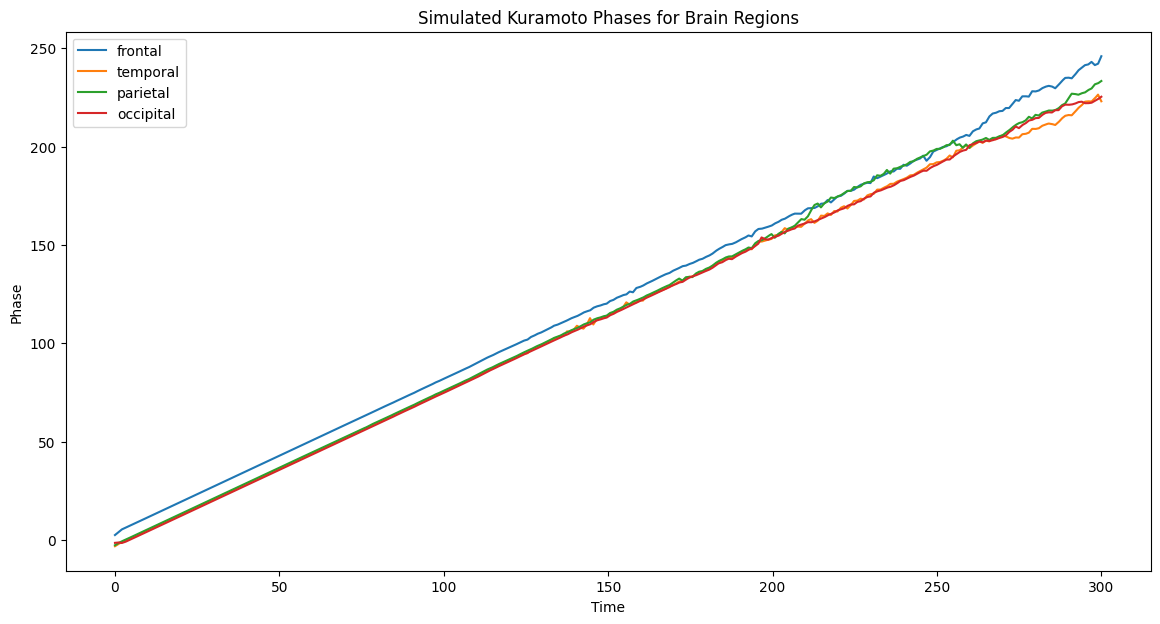

In [22]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.signal import hilbert
import matplotlib.pyplot as plt
import os

# Set random seed for consistent results
np.random.seed(42)

# Load EEG data
EEG_data = np.load('/home/vincent/AAA_projects/MVCS/Neuroscience/eeg_data_with_channels.npy', allow_pickle=True)

# EEG channel names
eeg_channel_names = ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6',
                     'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6',
                     'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2']

# Broad regions and corresponding channels
regions = {
    "frontal": ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8'],
    "temporal": ['T7', 'T8'],
    "parietal": ['CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8'],
    "occipital": ['O1', 'Oz', 'O2']
}

# Load PLV matrix
plv_matrix = np.load("/home/vincent/AAA_projects/MVCS/Neuroscience/Analysis/Phase Syncronization/plv_matrix.npy")

# Number of channels
N = len(eeg_channel_names)

# Set natural frequencies proportional to mean PLV of each channel
omega = np.mean(plv_matrix, axis=1)

# Phase bias based on mean phase difference between channels
phase_diff_matrix = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        if i != j:
            phase_diff = np.mean(np.angle(hilbert(EEG_data[:, i])) - np.angle(hilbert(EEG_data[:, j])))
            phase_diff_matrix[i, j] = phase_diff

# Use initial phases from the EEG data directly, not regions
initial_phases = np.angle(hilbert(EEG_data))[0, :]

# Modify the Kuramoto function to include weighted coupling and phase bias
def kuramoto_weighted_bias(t, y, omega, K):
    weighted_sin = plv_matrix * np.sin(y - y[:, np.newaxis] - phase_diff_matrix)
    dydt = omega + K/N * np.sum(weighted_sin, axis=1)
    return dydt

# Hilbert transform to get analytical signal
analytic_signal = hilbert(EEG_data)
phases = np.angle(analytic_signal)

# Average phase for the initial time point for each region
avg_phases = {}
for region, channels in regions.items():
    indices = [eeg_channel_names.index(ch) for ch in channels]
    avg_phases[region] = np.mean(phases[0, indices])

K = 5.0  # Coupling strength

# Time span for the simulation
t_span = (0, 300)
t_eval = np.linspace(t_span[0], t_span[1], 300) 

# Solve differential equations using the modified model
solution = solve_ivp(kuramoto_weighted_bias, t_span, initial_phases, t_eval=t_eval, args=(omega, K))

# The simulated Kuramoto phases
kuramoto_phases = solution.y

# Create a time axis for plotting
time_axis = np.linspace(t_span[0], t_span[1], 2 * len(EEG_data))

# Interpolating the Kuramoto phases to match the EEG data length
from scipy.interpolate import interp1d
interp_funcs = [interp1d(t_eval, kuramoto_phases[i, :]) for i in range(N)]
kuramoto_phases_interp = np.array([f(time_axis) for f in interp_funcs])

# Plot
plt.figure(figsize=(14, 7))
for i, region in enumerate(regions.keys()):
    plt.plot(time_axis, kuramoto_phases_interp[i, :], label=region, linewidth=1.5)

plt.legend()  # Place legend call here to ensure one entry per region
plt.xlabel('Time')
plt.ylabel('Phase')
plt.title('Simulated Kuramoto Phases for Brain Regions')

save_directory = "/home/vincent/AAA_projects/MVCS/Neuroscience/Modelling/Kuramoto"

# Check if the directory exists and create it if not
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

plot_path = os.path.join(save_directory, "Kuramoto_EEG_Channels_Plot.png")
plt.savefig(plot_path, dpi=300)  # Increased dpi for better resolution

# Save the simulated Kuramoto phases
kuramoto_data_path = os.path.join(save_directory, "kuramoto_phases_channels.npy")
np.save(kuramoto_data_path, kuramoto_phases)

print(f"Plot saved at {plot_path}")
print(f"Kuramoto phases saved at {kuramoto_data_path}")

plt.show()  # Show the plot at the end

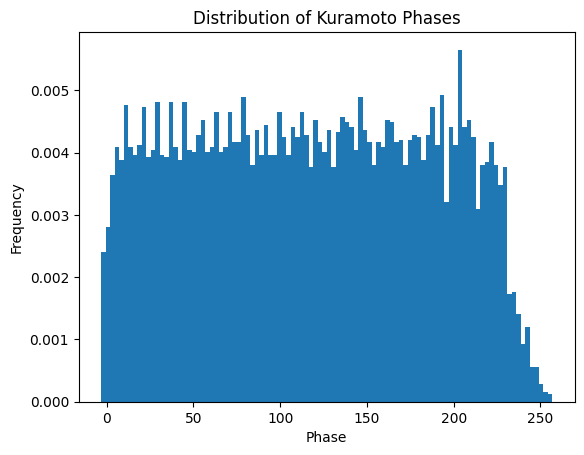

In [23]:
plt.hist(kuramoto_phases.ravel(), bins=100, density=True)
plt.xlabel('Phase')
plt.ylabel('Frequency')
plt.title('Distribution of Kuramoto Phases')
plt.show()

# Compare with EEG data

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert

def compute_phase_locking_value(signal1, signal2):
    phase1 = np.angle(hilbert(signal1))
    phase2 = np.angle(hilbert(signal2))
    phase_diff = phase1 - phase2
    PLV = abs(np.sum(np.exp(1j * phase_diff))) / len(phase_diff)
    return PLV


# List of EEG channels
eeg_channel_names = ['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6',
                    'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6',
                    'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2']

num_channels = len(eeg_channel_names)

# Load the precomputed EEG PLVs
eeg_plv_path = "/home/vincent/AAA_projects/MVCS/Neuroscience/Analysis/Phase Syncronization/plv_matrix.npy"
plv_matrix = np.load(eeg_plv_path)

# Compute Kuramoto model channel PLVs
kuramoto_channel_phases = ...  # Assuming you have Kuramoto phase data for each channel
kuramoto_channel_plvs = np.zeros((num_channels, num_channels))
for i in range(num_channels):
    for j in range(num_channels):
        if i != j:
            kuramoto_channel_plvs[i, j] = compute_phase_locking_value(kuramoto_channel_phases[:, i], kuramoto_channel_phases[:, j])

# Visualize channel-wise EEG PLVs and channel-wise Kuramoto PLVs
plt.figure(figsize=(20, 10))

# Plot for real EEG data
plt.subplot(2, 2, 1)
plt.imshow(plv_matrix, cmap="viridis", interpolation="none")
plt.colorbar(label="PLV")
plt.title("EEG Channel PLV")
plt.xticks(np.arange(num_channels), eeg_channel_names, rotation=90)
plt.yticks(np.arange(num_channels), eeg_channel_names)

# Plot for Kuramoto model channel-wise
plt.subplot(2, 2, 2)
plt.imshow(kuramoto_channel_plvs, cmap="viridis", interpolation="none")
plt.colorbar(label="PLV")
plt.title("Kuramoto Channel PLV")
plt.xticks(np.arange(num_channels), eeg_channel_names, rotation=90)
plt.yticks(np.arange(num_channels), eeg_channel_names)

# Assuming you've computed regional Kuramoto PLVs as kuramoto_plv_matrix
plt.subplot(2, 2, 3)
plt.imshow(kuramoto_plv_matrix, cmap="viridis", interpolation="none")
plt.colorbar(label="PLV")
plt.title("Kuramoto Regional PLV")
plt.xticks(np.arange(N), regions.keys(), rotation=90)
plt.yticks(np.arange(N), regions.keys())

plt.tight_layout()
plt.show()

TypeError: 'ellipsis' object is not subscriptable

# Feature Extraction

In [ ]:
# Normalization, since phases from the Kuramoto model will be between 0 and 2*pi, 
normalized_phases = kuramoto_phases / (2 * np.pi)

# Feature Creation
instantaneous_frequency = np.vstack([np.zeros(normalized_phases.shape[0]),
                                     np.diff(normalized_phases, axis=1)])

# Combining both the normalized phases and instantaneous frequency for a richer feature set
features = np.vstack([normalized_phases, instantaneous_frequency]).T

# Printing the head (first 5 rows)
print(features[:5])

# Save the features as a .npy file for future use
np.save('/home/vincent/AAA_projects/MVCS/Neuroscience/Modelling/Kuramoto/kuramoto_features.npy', features)


# Bifurcation 

In [ ]:
def compute_order_parameter(phases):
    """Compute the order parameter r from the phases."""
    return np.abs(np.mean(np.exp(1j * phases), axis=0))

# Bifurcation analysis
K_values = np.linspace(0, 5, 50)  # Change the range and number of points as needed
r_values = []

for K in K_values:
    solution = solve_ivp(kuramoto, t_span, initial_phases, t_eval=t_eval, args=(omega, K))
    r = compute_order_parameter(solution.y)
    r_values.append(np.mean(r[-int(desired_length * 0.1):]))  # average of the last 10% to ensure steady-state

# Plot bifurcation diagram
plt.figure(figsize=(12, 6))
plt.plot(K_values, r_values, '-o')
plt.xlabel('Coupling Strength K')
plt.ylabel('Order Parameter r')
plt.title('Bifurcation Diagram of Kuramoto Model')
plt.tight_layout()

bifurcation_plot_path = os.path.join(save_directory, "Kuramoto_Bifurcation_Plot.png")
plt.savefig(bifurcation_plot_path)

print(f"Bifurcation plot saved at {bifurcation_plot_path}")